### **Tutorial:MTG**

This experiment utilizes the human Middle Temporal Gyrus (MTG) dataset, which includes spatial transcriptomics data from both donors with Alzheimer's Disease (AD) and cognitively normal controls. In this tutorial, we use the normal sample as a representative example to demonstrate SpatialModal's capability to accurately identify cortical layers and characterize the spatial organization of the healthy brain.

#### **Loading package**

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
from Spatialmodal.spatialmodal import SpatialModal
from Spatialmodal.reconstruction import RF
from Spatialmodal.data_process import load_ST_file
from Spatialmodal.utils import mclust_R
from sklearn.decomposition import PCA
import scanpy as sc
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

#### **Loading ST data**

In [ ]:
stage = '2-5'
fold = f"../Data/MTG/{stage}"
adata = load_ST_file(fold)
truth = pd.read_csv("../Data/MTG//metadata.csv", index_col=0)
truth = truth[truth['patientID']=='2_5']
adata.obs['region'] = truth['Layer'].to_numpy()
adata.obs['region'] = adata.obs['region'].astype('category')
n_clusters = adata.obs['region'].nunique()

#### **Training the modal**

In [5]:
model = SpatialModal(adata, device=device, epochs=1000, fold=fold, image_use=True, if_img=True)
adata = model.train()

Tiling image: 100%|██████████ [ time left: 00:00 ]
Extracting features: 100%|██████████ [ time left: 00:00 ]
Training SpatialModal: 100%|██████████ [ time left: 00:00 ]


#### **Spatial clustering**

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


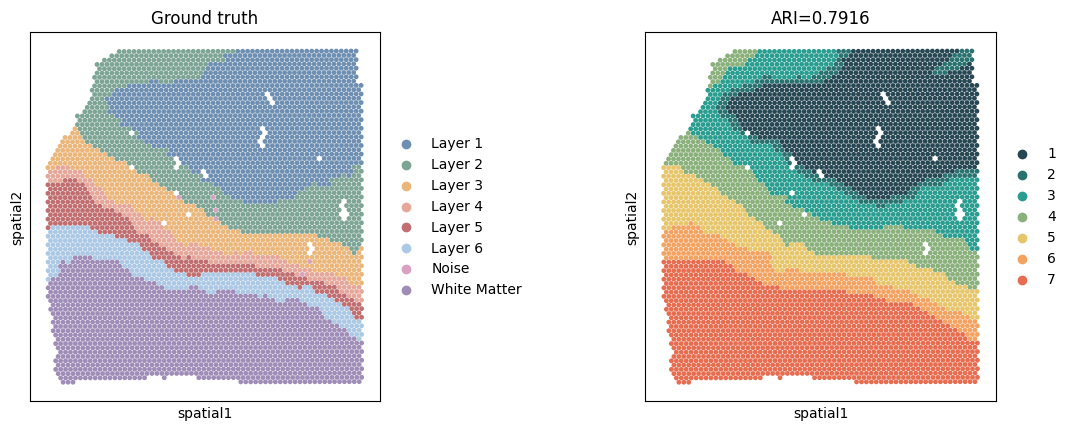

In [6]:
pca = PCA(n_components=20, random_state=42)
embedding = pca.fit_transform(adata.obsm['emb'].copy())
adata.obsm['emb_pca'] = embedding
mclust_R(adata, n_clusters, use_rep='emb_pca', key_added='domain')

ARI = metrics.adjusted_rand_score(adata.obs['region'], adata.obs['domain'])
sc.pl.spatial(adata,
              img_key=None,
              color=["region", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True,
              size=1.5)